In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from tensorflow.keras.layers import Bidirectional, BatchNormalization, Attention
import tensorflow as tf

In [3]:
# Load the dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

# Display the first few rows
print(df.head())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check the distribution of labels
print("Label distribution:\n", df['label'].value_counts())

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)
class_weight_dict = dict(zip(np.unique(df['label']), class_weights))
print("Class weights:", class_weight_dict)

# Add text-based features
df['message_length'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().str.len()
df['contains_currency'] = df['message'].str.contains('[$£€]').astype(int)
df['contains_numbers'] = df['message'].str.contains('\d').astype(int)
df['contains_exclamation'] = df['message'].str.count('!').astype(int)
df['capital_ratio'] = df['message'].str.count(r'[A-Z]') / df['message'].str.len()

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf.fit_transform(df['message'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Missing values:
 label      0
message    0
dtype: int64
Label distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64
Class weights: {'ham': 0.5774093264248704, 'spam': 3.7295850066934406}


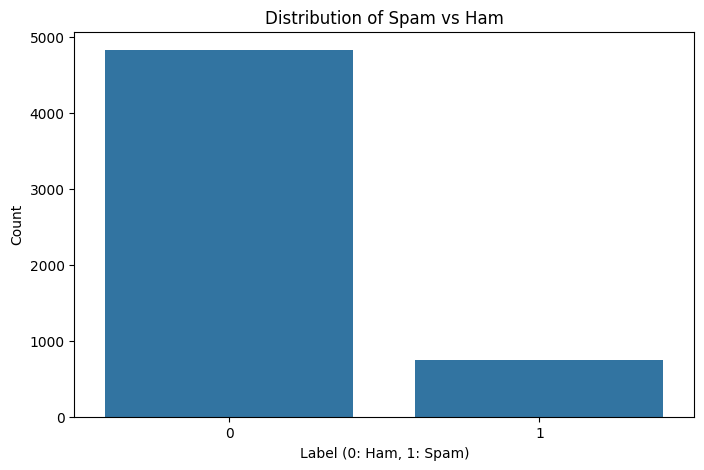

In [4]:
# Encode labels: ham -> 0, spam -> 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Visualize the distribution of spam vs ham
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs Ham')
plt.xlabel('Label (0: Ham, 1: Spam)')
plt.ylabel('Count')
plt.show()

In [5]:
# Convert text to lowercase and remove punctuation
df['message'] = df['message'].str.lower()
df['message'] = df['message'].str.replace('[^\w\s]', '')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Display the shapes of the splits
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (4457,)
Testing data shape: (1115,)


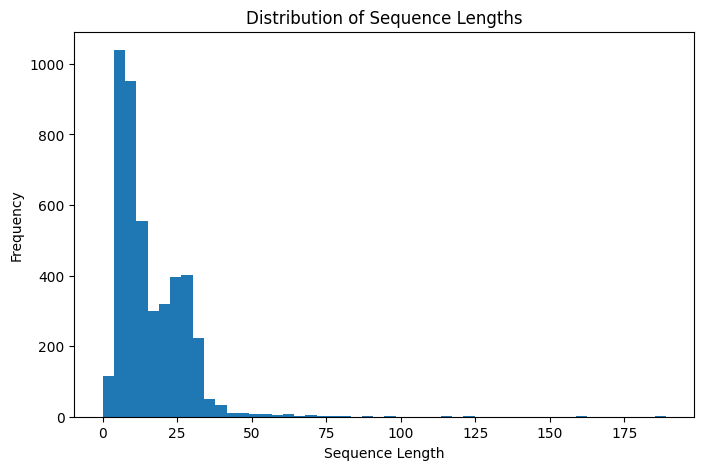

Original distribution: Counter({0: 3859, 1: 598})
Balanced distribution: Counter({0: 3859, 1: 3859})


In [6]:
# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
max_len = 100  # Maximum sequence length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Visualize sequence lengths
plt.figure(figsize=(8, 5))
plt.hist([len(seq) for seq in X_train_seq], bins=50)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_pad_reshaped = X_train_pad.reshape(X_train_pad.shape[0], -1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pad_reshaped, y_train)
X_train_balanced = X_train_balanced.reshape(-1, max_len)

print("Original distribution:", Counter(y_train))
print("Balanced distribution:", Counter(y_train_balanced))

In [7]:
# Define custom attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                shape=(input_shape[-1], 1),
                                initializer='random_normal',
                                trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                shape=(input_shape[1], 1),
                                initializer='zeros',
                                trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Enhanced model architecture
model = Sequential([
    Embedding(input_dim=10000, output_dim=256, input_length=max_len,
             embeddings_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    Bidirectional(LSTM(256, return_sequences=True,
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4))),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    AttentionLayer(),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Use a custom optimizer with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile with weighted metrics
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_test_pad, y_test),
    epochs=1,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

242/242 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.9929 - auc: 0.9996 - loss: 0.0938 - precision: 0.9931 - recall: 0.9926 - val_accuracy: 0.9794 - val_auc: 0.9745 - val_loss: 0.1589 - val_precision: 0.9375 - val_recall: 0.9060


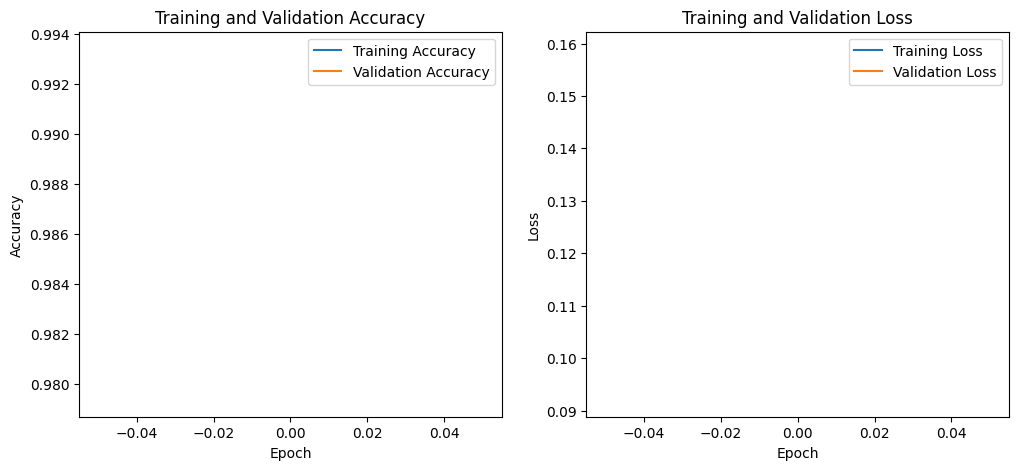

In [12]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [13]:
# Save the trained model
model.save('spam_classifier_lstm.h5')
print("Model saved as 'spam_classifier_lstm.h5'")

Model saved as 'spam_classifier_lstm.h5'


In [17]:
from tensorflow.keras.models import load_model
import re

# Load the saved model
loaded_model = load_model('spam_classifier_lstm.h5', custom_objects={'AttentionLayer': AttentionLayer})

# Enhanced prediction function with custom threshold
def predict_spam(text, threshold=0.5):
    # Preprocess
    processed_text = text.lower()
    processed_text = re.sub('[^\w\s]', '', processed_text)

    # Get prediction
    seq = tokenizer.texts_to_sequences([processed_text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred_probability = model.predict(pad, verbose=0)[0][0]

    # Calculate spam indicators
    spam_indicators = 0
    spam_indicators += bool(re.search('free|win|won|winner|prize|urgent|congrat|cash|money|claim|reward', processed_text.lower()))
    spam_indicators += bool(re.search('[$£€]\d+', text))
    spam_indicators += text.count('!') > 2
    spam_indicators += sum(1 for c in text if c.isupper()) / len(text) > 0.3 if len(text) > 0 else 0

    # Adjust threshold based on spam indicators
    adjusted_threshold = threshold - (0.05 * spam_indicators)

    print(f"Text: {text}")
    print(f"Spam indicators: {spam_indicators}")
    print(f"Raw probability: {pred_probability:.3f}")
    print(f"Adjusted threshold: {adjusted_threshold:.3f}")

    return "Spam" if pred_probability > adjusted_threshold else "Ham"

# Test the model
test_messages = [
    "URGENT! You have won a 1000 dollar Walmart gift card. FREE! Click here to claim now!",
    "Hi Mom, what time should I come over for dinner tonight?",
    "WINNER!! As a valued network customer you have been selected to receivea £900 prize reward!",
    "Meeting at 3pm tomorrow in the conference room",
    "FREE GUARANTEED! £100 prize award - call now 09064019788",
    "Hey, do you want to grab lunch?",
    "Your parcel will be delivered today",
    "Dear valued customer, your recent transaction has been flagged for review. Please verify your account details immediately to avoid service disruption. Visit secure-banking.com to confirm your identity."
]

for msg in test_messages:
    print("\n" + "="*50)
    print(predict_spam(msg))


Text: URGENT! You have won a 1000 dollar Walmart gift card. FREE! Click here to claim now!
Spam indicators: 2
Raw probability: 1.000
Adjusted threshold: 0.400
Spam

Text: Hi Mom, what time should I come over for dinner tonight?
Spam indicators: 0
Raw probability: 0.000
Adjusted threshold: 0.500
Ham

Text: WINNER!! As a valued network customer you have been selected to receivea £900 prize reward!
Spam indicators: 3
Raw probability: 0.970
Adjusted threshold: 0.350
Spam

Text: Meeting at 3pm tomorrow in the conference room
Spam indicators: 0
Raw probability: 0.001
Adjusted threshold: 0.500
Ham

Text: FREE GUARANTEED! £100 prize award - call now 09064019788
Spam indicators: 2
Raw probability: 0.998
Adjusted threshold: 0.400
Spam

Text: Hey, do you want to grab lunch?
Spam indicators: 0
Raw probability: 0.000
Adjusted threshold: 0.500
Ham

Text: Your parcel will be delivered today
Spam indicators: 0
Raw probability: 0.000
Adjusted threshold: 0.500
Ham

Text: Dear valued customer, your rece